# Calculate integrated vapour transport

In [38]:
import intake
import healpy
import dask

In [39]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

# Note: pass in chunks explicitly, see https://github.com/nextGEMS/catalog/issues/98
cat.ICON['ngc3028'].describe()['args']
zarr_source = cat.ICON['ngc3028'](zoom=9, time='P1D', chunks={'level_full': -1})
ds = zarr_source.to_dask()
ds.hus

<xarray.DataArray 'hus' (time: 2010, level_full: 90, cell: 3145728)>
dask.array<open_dataset-6a03584779646604322facf70dd538e1hus, shape=(2010, 90, 3145728), dtype=float32, chunksize=(1, 90, 262144), chunktype=numpy.ndarray>
Coordinates:
  * level_full  (level_full) int32 1 2 3 4 5 6 7 8 9 ... 83 84 85 86 87 88 89 90
  * time        (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2025-07-22
    zg          (level_full, cell) float32 dask.array<chunksize=(90, 262144), meta=np.ndarray>
Dimensions without coordinates: cell
Attributes:
    cell_methods:   time: mean cell: mean
    component:      atmo
    grid_mapping:   crs
    long_name:      Specific humidity
    standard_name:  specific_humidity
    vgrid:          reference

In [24]:
# Calculate ivt
gravity = 9.81
dp = ds.phalf.diff('level_half').rename(level_half='level_full').assign_coords(level_full = ds.level_full)  # diff shifts half-level so values don't match
iv = (ds.hus * dp).sum("level_full") / gravity
# iv_u = (ds.hus * dp * ds.ua).sum('level_full') / gravity
# iv_v = (ds.hus * dp * ds.va).sum('level_full') / gravity

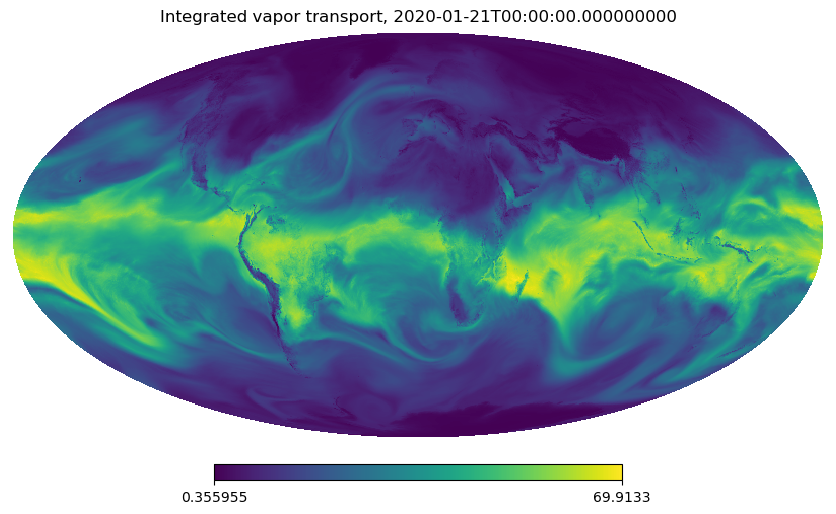

In [49]:
# Plot first timestep just to check
healpy.mollview(iv.isel(time=1).values, nest=True, flip="geo", title=f"Integrated vapor transport, {ds.time[0].values}")

# Processing entire dataset

Save intermediate data as per https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    iv.to_zarr("/scratch/b/b381307/iv.zarr")

In [36]:
# Reload and take temporal mean
import xarray as xr
import healpy
mean = xr.open_dataarray('/scratch/b/b381307/iv.zarr', engine='zarr', chunks={}).rename('iv').mean('time')

<xarray.DataArray 'iv' (cell: 3145728)>
dask.array<mean_agg-aggregate, shape=(3145728,), dtype=float32, chunksize=(262144,), chunktype=numpy.ndarray>
Dimensions without coordinates: cell

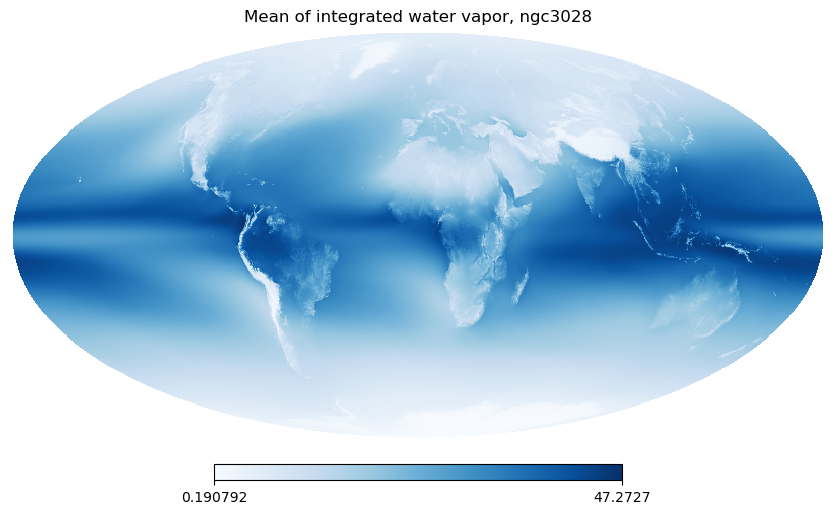

In [44]:
healpy.mollview(mean.values, nest=True, flip="geo", title=f"Mean of integrated water vapor, ngc3028", cmap='Blues')

# Refactor into function

In [40]:
import xarray as xr

def calculate_ivt(hus, ua, va, phalf):
    """Calculate integrated water vapour transport.
    
    Works for ICON data on model levels.
    """
    gravity = 9.81
    dp = phalf.diff('level_half').rename(level_half='level_full').assign_coords(level_full = ds.level_full)  # diff shifts half-level so values don't match
    iv = (hus * dp).sum("level_full") / gravity
    iv_u = (hus * dp * ua).sum('level_full') / gravity
    iv_v = (hus * dp * va).sum('level_full') / gravity

    ivt = xr.merge([iv.rename('iv'), iv_u.rename('iv_u'), iv_v.rename('iv_v')])
    return ivt.chunk({'cell': -1})  # Now comfortably fits in memory (12mb per chunk at zoom 9)

ivt = calculate_ivt(ds.hus, ds.ua, ds.va, ds.phalf)
ivt

<xarray.Dataset>
Dimensions:  (time: 2010, cell: 3145728)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2025-07-22
Dimensions without coordinates: cell
Data variables:
    iv       (time, cell) float32 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    iv_u     (time, cell) float32 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    iv_v     (time, cell) float32 dask.array<chunksize=(1, 3145728), meta=np.ndarray>

# Remapping to lat/lon

In [42]:
# Remap to rectilinear lat/lon so we can plot quivers
import numpy as np
import xarray as xr
import cartopy
import matplotlib.pyplot as plt

lon = np.arange(0, 360, 1)
lat = np.arange(90, -91, -1)
grid_indices = xr.DataArray(
    healpy.ang2pix(ds.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)),
)

# Alternatively could use heaply.get_interp_val for bilinear interpolation instead of nearest neighbor ??
iv_latlon = ivt.iv.isel(cell=grid_indices)
ivu_latlon = ivt.iv_u.isel(cell=grid_indices)
ivv_latlon = ivt.iv_v.isel(cell=grid_indices)

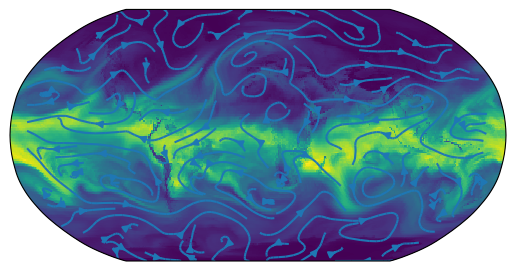

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.Robinson())
ax.pcolormesh(lon, lat, iv_latlon.isel(time=0)/gravity, transform=cartopy.crs.PlateCarree())
ax.streamplot(lon, lat, ivu_latlon.isel(time=0)/gravity, ivv_latlon.isel(time=0)/gravity, transform=cartopy.crs.PlateCarree())

# Try reading online data

This also works on my laptop

In [48]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/online.yaml")
ds = cat.ICON['ngc3028'](zoom=2, time='P1D').to_dask()
ds.hhus

<xarray.Dataset>
Dimensions:                              (time: 1350, depth_half: 129,
                                          cell: 192, level_full: 90, crs: 1,
                                          depth_full: 128,
                                          soil_depth_water_level: 5,
                                          level_half: 91,
                                          soil_depth_energy_level: 5)
Coordinates:
  * crs                                  (crs) float32 nan
  * depth_full                           (depth_full) float32 1.0 ... 5.904e+03
  * depth_half                           (depth_half) float32 0.0 ... 6.003e+03
  * level_full                           (level_full) int32 1 2 3 4 ... 88 89 90
  * level_half                           (level_half) int32 1 2 3 4 ... 89 90 91
  * soil_depth_energy_level              (soil_depth_energy_level) float32 0....
  * soil_depth_water_level               (soil_depth_water_level) float32 0.0...
  * time                                 (time) datetime64[ns] 2020-01-21 ......
Dimensions without coordinates: cell
Data variables: (12/88)
    a_tracer_v_to                        (time, depth_half, cell) float32 ...
    atmos_fluxes_frshflux_evaporation    (time, cell) float32 ...
    atmos_fluxes_frshflux_precipitation  (time, cell) float32 ...
    atmos_fluxes_frshflux_runoff         (time, cell) float32 ...
    atmos_fluxes_frshflux_snowfall       (time, cell) float32 ...
    atmos_fluxes_heatflux_latent         (time, cell) float32 ...
    ...                                   ...
    va                                   (time, level_full, cell) float32 ...
    vas                                  (time, cell) float32 ...
    w                                    (time, depth_half, cell) float32 ...
    wa_phy                               (time, level_half, cell) float32 ...
    wind_speed_10m                       (time, cell) float32 ...
    zos                                  (time, cell) float32 ...